<a href="https://colab.research.google.com/github/Edgar121207/MSCI-151/blob/main/CourseWork5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Data Preparation**

In [192]:
!pip install pulp
from IPython.core.display import publish_display_data
import pulp as pl
from collections import defaultdict
import os
import csv


In [193]:
baristas=["Max","Jiwa","Fore","Donna","Paul"]
days= list(range(1,7))
blocks=list(range(1,5))
H=4
cost={"Max":50000,"Jiwa":50000,"Fore":50000,"Donna":150000,"Paul":150000}
etype={"Max":"P","Jiwa":"P","Fore":"P","Donna":"F","Paul":"F"}
minWeekly_default={"Max":12,"Jiwa":12,"Fore":12,"Donna":36,"Paul":36}

In [194]:
avail={("Max",1):8,("MAx",2):8,("Max",3):8,("Max",4):0,("Max",5):8,("Max",6):4,("Max",7):4,("Jiwa",1):4,("Jiwa",2):4,("Jiwa",3):8,("Jiwa",4):8,("Jiwa",5):0,("Jiwa",6):4,("Jiwa",7):0,("Fore",1):8,("Fore",2):0,("Fore",3):8,("Fore",4):8,("Fore",5):8,("Fore",6):8,("Fore",7):0,("Donna",1):12,("Donna",2):12,("Donna",3):12,("Donna",4):12,("Donna",5):12,("Donna",6):12,("Donna",7):8,("Paul",1):12,("Paul",2):8,("Paul",3):12,("Paul",4):12,("Paul",5):8,("Paul",6):12,("Paul",7):12,}

In [195]:
DAY_NAME={1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday",7:"Sunday"}
BLOCK_NAME={1:"07:00-11:00",2:"11:00-15:00",3:"15:00-19:00",4:"19:00-23:00"}


##**Shift Assignment**

##Constraints

In [196]:
# Constraint (New): At Least One Barista Per Block
# For every day 'd' and block 'b', the sum of assigned baristas must be >= 1.
for d in days:
    for b in blocks:
        constraint_name = f"At_Least_One_Barista_Per_Block_{d}_{b}"
        # If the constraint already exists, remove it before adding to prevent 'overlapping constraint names' error
        if constraint_name in prob.constraints:
            del prob.constraints[constraint_name]
        prob += pl.lpSum(y[(o, d, b)] for o in baristas) >= 1, constraint_name

In [197]:
# Constraint 1: Barista Availability (per day, per barista)
for o in baristas:
    for d in days:
        max_blocks_on_day = avail.get((o, d), 0) // H
        constraint_name = f"Availability_MaxBlocks_{o}_{d}"
        # If the constraint already exists, remove it before adding to prevent 'overlapping constraint names' error
        if constraint_name in prob.constraints:
            del prob.constraints[constraint_name]
        prob += pl.lpSum(y[(o, d, b)] for b in blocks) <= max_blocks_on_day, constraint_name

In [198]:
# Constraint 2: Maximum Daily Blocks by Employment Type
for o in baristas:
    for d in days:
        # Calculate the sum of assigned blocks for barista 'o' on day 'd'
        assigned_blocks_on_day = pl.lpSum(y[(o, d, b)] for b in blocks)

        if etype[o] == 'P': # Part-time barista
            max_daily_blocks = 2
        elif etype[o] == 'F': # Full-time barista
            max_daily_blocks = 3
        else:
            # Handle cases where employment type might be undefined or different
            # For now, we can raise an error or set a default/skip
            max_daily_blocks = 4 # Or some other sensible default if needed
            # raise ValueError(f"Unknown employment type for barista {o}: {etype[o]}")

        constraint_name = f"Max_Daily_Blocks_by_Type_{o}_{d}"
        # Remove existing constraint if re-running to avoid overlapping names error
        if constraint_name in prob.constraints:
            del prob.constraints[constraint_name]

        prob += assigned_blocks_on_day <= max_daily_blocks, constraint_name

In [199]:
# Constraint 3: Minimum Weekly Hours for Baristas
# Each barista 'o' must work at least minWeekly_default[o] hours over the week.
for o in baristas:
    # Calculate total hours worked by barista 'o' across all days and blocks
    total_weekly_hours_worked = pl.lpSum(y[(o, d, b)] * H for d in days for b in blocks)

    constraint_name = f"Min_Weekly_Hours_{o}"
    # If the constraint already exists, remove it before adding to prevent 'overlapping constraint names' error
    if constraint_name in prob.constraints:
        del prob.constraints[constraint_name]

    prob += total_weekly_hours_worked >= minWeekly_default[o], constraint_name

## **Solve the Optimization Problem**

This section solves the defined MILP problem using PuLP's default solver and checks the status of the solution.

In [200]:
# The problem is solved using PuLP's default solver
prob.solve()

# Print the status of the solution
print("Status:", pl.LpStatus[prob.status])


Status: Optimal


In [201]:
# Print the optimal objective function value (total minimized cost)
print("Total Cost =", pl.value(prob.objective))

print("\n--- Barista Schedule ---")
# Create a dictionary to store the full schedule for better display
schedule = defaultdict(lambda: defaultdict(list))

# Populate the schedule and calculate weekly totals
barista_weekly_hours = defaultdict(int)
barista_weekly_cost = defaultdict(int)

for o in baristas:
    for d in days:
        for b in blocks:
            if y[(o, d, b)].varValue == 1:
                schedule[o][d].append(b)
                barista_weekly_hours[o] += H
                barista_weekly_cost[o] += H * cost[o]

# Display the schedule
for o in baristas:
    print(f"\nBarista: {o}")
    for d in sorted(schedule[o].keys()):
        day_name = DAY_NAME.get(d, f"Day {d}")
        block_times = [BLOCK_NAME.get(b, f"Block {b}") for b in schedule[o][d]]
        print(f"  {day_name}: {', '.join(block_times)}")
    print(f"  Weekly Hours: {barista_weekly_hours[o]} hours")
    print(f"  Weekly Cost: ${barista_weekly_cost[o]:,.2f}")


Total Cost = 12600000.0

--- Barista Schedule ---

Barista: Max
  Monday: 11:00-15:00
  Friday: 11:00-15:00, 19:00-23:00
  Weekly Hours: 12 hours
  Weekly Cost: $600,000.00

Barista: Jiwa
  Monday: 07:00-11:00
  Tuesday: 19:00-23:00
  Wednesday: 15:00-19:00
  Weekly Hours: 12 hours
  Weekly Cost: $600,000.00

Barista: Fore
  Thursday: 15:00-19:00
  Friday: 15:00-19:00
  Saturday: 15:00-19:00
  Weekly Hours: 12 hours
  Weekly Cost: $600,000.00

Barista: Donna
  Tuesday: 07:00-11:00, 11:00-15:00, 15:00-19:00
  Wednesday: 19:00-23:00
  Thursday: 07:00-11:00, 11:00-15:00, 15:00-19:00
  Saturday: 07:00-11:00, 11:00-15:00
  Weekly Hours: 36 hours
  Weekly Cost: $5,400,000.00

Barista: Paul
  Monday: 15:00-19:00, 19:00-23:00
  Tuesday: 15:00-19:00
  Wednesday: 07:00-11:00, 11:00-15:00
  Thursday: 11:00-15:00, 19:00-23:00
  Friday: 07:00-11:00
  Saturday: 19:00-23:00
  Weekly Hours: 36 hours
  Weekly Cost: $5,400,000.00


##**Decision Variable**

In [202]:
import pulp as pl

# Create a problem instance (this is necessary to define variables within a problem)
prob = pl.LpProblem("BaristaScheduling", pl.LpMinimize)

# Define the binary decision variables y_o,d,b
# y is a dictionary where keys are (barista, day, block) tuples
y = pl.LpVariable.dicts("Assign",
                        ((o, d, b) for o in baristas for d in days for b in blocks),
                        lowBound=0, upBound=1, cat='Binary')

print("Example of a decision variable for Max, Day 1, Block 1:")
print(y[('Max', 1, 1)])

print("\nTotal number of binary decision variables created:", len(y))

Example of a decision variable for Max, Day 1, Block 1:
Assign_('Max',_1,_1)

Total number of binary decision variables created: 120


##**Objective**

In [203]:
# Objective Function: Minimize Total Cost
# The objective is to minimize the sum of the cost of each barista multiplied by their assigned hours.
prob += pl.lpSum(y[(o, d, b)] * H * cost[o] for o in baristas for d in days for b in blocks), "Total_Cost"

print("Objective function added: Minimize Total Cost")

Objective function added: Minimize Total Cost


In [204]:
pl.lpSum(y[(o, d, b)] * H * cost[o] for o in baristas for d in days for b in blocks)

600000*Assign_('Donna',_1,_1) + 600000*Assign_('Donna',_1,_2) + 600000*Assign_('Donna',_1,_3) + 600000*Assign_('Donna',_1,_4) + 600000*Assign_('Donna',_2,_1) + 600000*Assign_('Donna',_2,_2) + 600000*Assign_('Donna',_2,_3) + 600000*Assign_('Donna',_2,_4) + 600000*Assign_('Donna',_3,_1) + 600000*Assign_('Donna',_3,_2) + 600000*Assign_('Donna',_3,_3) + 600000*Assign_('Donna',_3,_4) + 600000*Assign_('Donna',_4,_1) + 600000*Assign_('Donna',_4,_2) + 600000*Assign_('Donna',_4,_3) + 600000*Assign_('Donna',_4,_4) + 600000*Assign_('Donna',_5,_1) + 600000*Assign_('Donna',_5,_2) + 600000*Assign_('Donna',_5,_3) + 600000*Assign_('Donna',_5,_4) + 600000*Assign_('Donna',_6,_1) + 600000*Assign_('Donna',_6,_2) + 600000*Assign_('Donna',_6,_3) + 600000*Assign_('Donna',_6,_4) + 200000*Assign_('Fore',_1,_1) + 200000*Assign_('Fore',_1,_2) + 200000*Assign_('Fore',_1,_3) + 200000*Assign_('Fore',_1,_4) + 200000*Assign_('Fore',_2,_1) + 200000*Assign_('Fore',_2,_2) + 200000*Assign_('Fore',_2,_3) + 200000*Assign_(

##Fairness Variant

# Task
Implement the fairness variant of the barista scheduling problem. This involves defining new variables for maximum and minimum weekly hours (`H_max`, `H_min`), adding constraints to link these to individual barista weekly hours, re-adding all previously defined constraints (Availability, At Least One Barista Per Block, Maximum Daily Blocks by Employment Type, Minimum Weekly Hours for Baristas, and Maximum Weekly Hours from Availability) to the new problem, introducing a budget constraint where the total cost (`Z_fair`) does not exceed 1.02 times the optimal cost of the original cost-minimizing solution (`Z_baseline`), and modifying the objective function to minimize the difference between `H_max` and `H_min`. Finally, solve this fairness variant problem, interpret the solution by printing the status, new total cost, `H_max`, `H_min`, and the fairness gap, and display the detailed barista schedule. Summarize the results and compare them to the original cost-minimizing solution.

## Add Constraints for H_max and H_min

### Subtask:
Define new variables for maximum (H_max) and minimum (H_min) weekly hours across all baristas. Then, add constraints to link each barista's total weekly hours to these global H_max and H_min variables.


**Reasoning**:
The subtask requires defining new variables for `H_max` and `H_min` and constraints to link each barista's total weekly hours to these new variables within a reinitialized problem instance for fairness. This step initializes `prob_fair`, `y_fair`, `H_max`, and `H_min`, and then adds the necessary constraints.



In [205]:
import pulp as pl

# 1. Reinitialize the problem instance for the fairness variant
prob_fair = pl.LpProblem("BaristaSchedulingFairness", pl.LpMinimize)

# 2. Define new binary decision variables y_fair
y_fair = pl.LpVariable.dicts("Assign_Fair",
                            ((o, d, b) for o in baristas for d in days for b in blocks),
                            lowBound=0, upBound=1, cat='Binary')

# 3. Define H_max as a continuous PuLP variable
H_max = pl.LpVariable("H_Max_Hours", lowBound=0, cat='Continuous')

# 4. Define H_min as a continuous PuLP variable
H_min = pl.LpVariable("H_Min_Hours", lowBound=0, cat='Continuous')

# 5. Calculate total_weekly_hours for each barista
barista_total_weekly_hours = {}
for o in baristas:
    barista_total_weekly_hours[o] = pl.lpSum(y_fair[(o, d, b)] * H for d in days for b in blocks)

# 6. Add constraints: total_weekly_hours <= H_max for each barista
for o in baristas:
    constraint_name = f"Barista_Hours_LE_H_Max_{o}"
    prob_fair += barista_total_weekly_hours[o] <= H_max, constraint_name

# 7. Add constraints: total_weekly_hours >= H_min for each barista
for o in baristas:
    constraint_name = f"Barista_Hours_GE_H_Min_{o}"
    prob_fair += barista_total_weekly_hours[o] >= H_min, constraint_name

print("Fairness problem instance (prob_fair) and associated variables (y_fair, H_max, H_min) defined.")
print("Constraints linking barista weekly hours to H_max and H_min added.")

Fairness problem instance (prob_fair) and associated variables (y_fair, H_max, H_min) defined.
Constraints linking barista weekly hours to H_max and H_min added.


**Reasoning**:
The next step in the overall task is to re-add the previously defined constraints to the new problem instance `prob_fair`. I will start by adding the 'At Least One Barista Per Block' constraint, using the `y_fair` decision variables.



In [206]:
for d in days:
    for b in blocks:
        constraint_name = f"At_Least_One_Barista_Per_Block_Fair_{d}_{b}"
        # Add constraint to prob_fair using y_fair variables
        prob_fair += pl.lpSum(y_fair[(o, d, b)] for o in baristas) >= 1, constraint_name

print("Constraint: At Least One Barista Per Block added to prob_fair.")

Constraint: At Least One Barista Per Block added to prob_fair.


**Reasoning**:
The next step is to re-add 'Constraint 1: Barista Availability (per day, per barista)' to the `prob_fair` problem instance, using the `y_fair` decision variables and existing availability data.



In [207]:
for o in baristas:
    for d in days:
        max_blocks_on_day = avail.get((o, d), 0) // H
        constraint_name = f"Availability_MaxBlocks_Fair_{o}_{d}"
        # Add constraint to prob_fair using y_fair variables
        prob_fair += pl.lpSum(y_fair[(o, d, b)] for b in blocks) <= max_blocks_on_day, constraint_name

print("Constraint 1: Barista Availability (per day, per barista) added to prob_fair.")

Constraint 1: Barista Availability (per day, per barista) added to prob_fair.


**Reasoning**:
The next step is to re-add 'Constraint 2: Maximum Daily Blocks by Employment Type' to the `prob_fair` problem instance, using the `y_fair` decision variables and the employment type data.



In [208]:
for o in baristas:
    for d in days:
        # Calculate the sum of assigned blocks for barista 'o' on day 'd'
        assigned_blocks_on_day = pl.lpSum(y_fair[(o, d, b)] for b in blocks)

        if etype[o] == 'P': # Part-time barista
            max_daily_blocks = 2
        elif etype[o] == 'F': # Full-time barista
            max_daily_blocks = 3
        else:
            # Handle cases where employment type might be undefined or different
            # For now, we can set a default
            max_daily_blocks = 4

        constraint_name = f"Max_Daily_Blocks_by_Type_Fair_{o}_{d}"
        prob_fair += assigned_blocks_on_day <= max_daily_blocks, constraint_name

print("Constraint 2: Maximum Daily Blocks by Employment Type added to prob_fair.")

Constraint 2: Maximum Daily Blocks by Employment Type added to prob_fair.


**Reasoning**:
The next step is to re-add 'Constraint 3: Minimum Weekly Hours for Baristas' to the `prob_fair` problem instance, using the `y_fair` decision variables and the `minWeekly_default` data.



In [209]:
for o in baristas:
    # Calculate total hours worked by barista 'o' across all days and blocks
    total_weekly_hours_worked_fair = pl.lpSum(y_fair[(o, d, b)] * H for d in days for b in blocks)

    constraint_name = f"Min_Weekly_Hours_Fair_{o}"

    prob_fair += total_weekly_hours_worked_fair >= minWeekly_default[o], constraint_name

print("Constraint 3: Minimum Weekly Hours for Baristas added to prob_fair.")

Constraint 3: Minimum Weekly Hours for Baristas added to prob_fair.


**Reasoning**:
The next step is to re-add the 'Maximum Weekly Hours from Availability' constraint to the `prob_fair` problem instance. This constraint limits the total weekly hours a barista can work based on their declared availability.



In [210]:
for o in baristas:
    total_potential_avail_hours = sum(avail.get((o, d), 0) for d in days)
    constraint_name = f"Max_Weekly_Hours_Availability_Fair_{o}"
    prob_fair += pl.lpSum(y_fair[(o, d, b)] * H for d in days for b in blocks) <= total_potential_avail_hours, constraint_name

print("Constraint: Maximum Weekly Hours from Availability added to prob_fair.")

Constraint: Maximum Weekly Hours from Availability added to prob_fair.


**Reasoning**:
Now, a budget constraint needs to be added to the `prob_fair` problem. This constraint will ensure that the total cost of the fairness variant solution does not exceed 1.02 times the optimal cost (`Z_baseline`) found in the original cost-minimizing solution. The `Z_baseline` value was already computed and is available in the kernel state.



In [211]:
import pulp as pl

# Calculate the total cost for the fairness variant using y_fair variables
Z_fair = pl.lpSum(y_fair[(o, d, b)] * H * cost[o] for o in baristas for d in days for b in blocks)

# Define the budget constraint
budget_constraint_value = 1.02 * Z_baseline
prob_fair += Z_fair <= budget_constraint_value, "Budget_Constraint"

print(f"Budget Constraint added: Total cost (Z_fair) <= 1.02 * Z_baseline (which is {budget_constraint_value:.2f})")

Budget Constraint added: Total cost (Z_fair) <= 1.02 * Z_baseline (which is 12852000.00)


**Reasoning**:
With all constraints re-added and the budget constraint in place, the next step is to modify the objective function of `prob_fair` to minimize the difference between `H_max` and `H_min`. This aligns with the fairness goal of the problem.



In [212]:
prob_fair += H_max - H_min, "Minimize_Fairness_Gap"

print("Objective function for fairness variant set to minimize (H_max - H_min).")

Objective function for fairness variant set to minimize (H_max - H_min).


**Reasoning**:
Now that the fairness variant problem (`prob_fair`) with its objective function and all constraints is fully defined, the next step is to solve it using PuLP's default solver. This will find the optimal solution that minimizes the fairness gap under the given constraints.



In [213]:
prob_fair.solve()

print("Status of Fairness Problem Solution:", pl.LpStatus[prob_fair.status])

Status of Fairness Problem Solution: Optimal


**Reasoning**:
After solving the fairness variant problem, the next step is to interpret the results by printing the key metrics: the fairness gap (H_max - H_min), the individual H_max and H_min values, and the new total cost. This provides a summary of the optimized fairness solution.



In [214]:
print("Optimal Fairness Gap (H_max - H_min) =", pl.value(prob_fair.objective))
print("Optimal H_max =", pl.value(H_max))
print("Optimal H_min =", pl.value(H_min))

# Calculate and print the new total cost (Z_fair) from the fairness solution
Z_fair_solved = pl.lpSum(y_fair[(o, d, b)].varValue * H * cost[o] for o in baristas for d in days for b in blocks)
print(f"New Total Cost (Z_fair) = ${pl.value(Z_fair_solved):,.2f}")

print("\n--- Fairness Barista Schedule ---")
# Create a dictionary to store the full schedule for better display
schedule_fair = defaultdict(lambda: defaultdict(list))

# Populate the schedule and calculate weekly totals
barista_weekly_hours_fair = defaultdict(int)
barista_weekly_cost_fair = defaultdict(int)

for o in baristas:
    for d in days:
        for b in blocks:
            if y_fair[(o, d, b)].varValue == 1:
                schedule_fair[o][d].append(b)
                barista_weekly_hours_fair[o] += H
                barista_weekly_cost_fair[o] += H * cost[o]

# Display the schedule
for o in baristas:
    print(f"\nBarista: {o}")
    for d in sorted(schedule_fair[o].keys()):
        day_name = DAY_NAME.get(d, f"Day {d}")
        block_times = [BLOCK_NAME.get(b, f"Block {b}") for b in schedule_fair[o][d]]
        print(f"  {day_name}: {', '.join(block_times)}")
    print(f"  Weekly Hours: {barista_weekly_hours_fair[o]} hours")
    print(f"  Weekly Cost: ${barista_weekly_cost_fair[o]:,.2f}")

Optimal Fairness Gap (H_max - H_min) = 24.0
Optimal H_max = 36.0
Optimal H_min = 12.0
New Total Cost (Z_fair) = $12,600,000.00

--- Fairness Barista Schedule ---

Barista: Max
  Wednesday: 15:00-19:00
  Friday: 11:00-15:00, 15:00-19:00
  Weekly Hours: 12 hours
  Weekly Cost: $600,000.00

Barista: Jiwa
  Wednesday: 11:00-15:00, 19:00-23:00
  Thursday: 15:00-19:00
  Weekly Hours: 12 hours
  Weekly Cost: $600,000.00

Barista: Fore
  Monday: 11:00-15:00
  Friday: 19:00-23:00
  Saturday: 11:00-15:00
  Weekly Hours: 12 hours
  Weekly Cost: $600,000.00

Barista: Donna
  Monday: 15:00-19:00, 19:00-23:00
  Tuesday: 07:00-11:00, 11:00-15:00, 19:00-23:00
  Thursday: 07:00-11:00, 11:00-15:00, 19:00-23:00
  Saturday: 15:00-19:00
  Weekly Hours: 36 hours
  Weekly Cost: $5,400,000.00

Barista: Paul
  Monday: 07:00-11:00, 19:00-23:00
  Tuesday: 15:00-19:00
  Wednesday: 07:00-11:00
  Thursday: 11:00-15:00
  Friday: 07:00-11:00, 19:00-23:00
  Saturday: 07:00-11:00, 19:00-23:00
  Weekly Hours: 36 hours
 

**Reasoning**:
The previous code failed because `Z_fair_solved` was an `LpAffineExpression` object, not a numerical value, when attempting to format it. I need to use `pl.value()` to extract the numerical solution from the `LpAffineExpression` before printing it with a format string.



In [215]:
import pandas as pd

print("Optimal Fairness Gap (H_max - H_min) =", pl.value(prob_fair.objective))
print("Optimal H_max =", pl.value(H_max))
print("Optimal H_min =", pl.value(H_min))

# Calculate and print the new total cost (Z_fair) from the fairness solution
# Use pl.value() to get the numerical result of the LpAffineExpression
Z_fair_solved = pl.lpSum(y_fair[(o, d, b)].varValue * H * cost[o] for o in baristas for d in days for b in blocks)
print(f"New Total Cost (Z_fair) = ${pl.value(Z_fair_solved):,.2f}")

print("\n--- Fairness Barista Schedule (Table Format) ---")

# Create a dictionary to store the full schedule for better display
schedule_data = []

# Populate the schedule and calculate weekly totals
barista_weekly_hours_fair = defaultdict(int)
barista_weekly_cost_fair = defaultdict(int)

for o in baristas:
    individual_schedule = defaultdict(list)
    for d in days:
        for b in blocks:
            if y_fair[(o, d, b)].varValue == 1:
                individual_schedule[d].append(b)
                barista_weekly_hours_fair[o] += H
                barista_weekly_cost_fair[o] += H * cost[o]

    # Format daily schedules for the table
    formatted_schedule = []
    for d in sorted(individual_schedule.keys()):
        day_name = DAY_NAME.get(d, f"Day {d}")
        block_times = [BLOCK_NAME.get(b, f"Block {b}") for b in individual_schedule[d]]
        formatted_schedule.append(f"{day_name}: {', '.join(block_times)}")

    schedule_data.append({
        "Barista": o,
        "Schedule": '\n'.join(formatted_schedule) if formatted_schedule else "No shifts",
        "Weekly Hours": barista_weekly_hours_fair[o],
        "Weekly Cost": barista_weekly_cost_fair[o] # Store as numerical value
    })

# Create and display the DataFrame
df_schedule = pd.DataFrame(schedule_data)
display(df_schedule)


Optimal Fairness Gap (H_max - H_min) = 24.0
Optimal H_max = 36.0
Optimal H_min = 12.0
New Total Cost (Z_fair) = $12,600,000.00

--- Fairness Barista Schedule (Table Format) ---


,Barista,Schedule,Weekly Hours,Weekly Cost
0,Max,"Wednesday: 15:00-19:00\nFriday: 11:00-15:00, 1...",12,600000
1,Jiwa,"Wednesday: 11:00-15:00, 19:00-23:00\nThursday:...",12,600000
2,Fore,Monday: 11:00-15:00\nFriday: 19:00-23:00\nSatu...,12,600000
3,Donna,"Monday: 15:00-19:00, 19:00-23:00\nTuesday: 07:...",36,5400000
4,Paul,"Monday: 07:00-11:00, 19:00-23:00\nTuesday: 15:...",36,5400000


## **Visualizing the Schedules: Comparison**

To effectively compare the original cost-minimizing schedule with the fairness variant, we'll first consolidate the original schedule data into a pandas DataFrame. Then, we can create visualizations to highlight the differences in weekly hours and costs for each barista.


In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# --- 1. Create DataFrame for Original Cost-Minimizing Schedule ---

schedule_original_data = []
barista_weekly_hours_original = defaultdict(int)
barista_weekly_cost_original = defaultdict(int)

# Extract the original schedule (from the 'y' variables) - ensure 'prob' is solved
# Note: This assumes 'prob' was the original problem instance already solved.
if prob.status == pl.LpStatusOptimal:
    for o in baristas:
        individual_schedule_orig = defaultdict(list)
        for d in days:
            for b in blocks:
                if y[(o, d, b)].varValue == 1:
                    individual_schedule_orig[d].append(b)
                    barista_weekly_hours_original[o] += H
                    barista_weekly_cost_original[o] += H * cost[o]

        formatted_schedule_orig = []
        for d in sorted(individual_schedule_orig.keys()):
            day_name = DAY_NAME.get(d, f"Day {d}")
            block_times = [BLOCK_NAME.get(b, f"Block {b}") for b in individual_schedule_orig[d]]
            formatted_schedule_orig.append(f"{day_name}: {', '.join(block_times)}")

        schedule_original_data.append({
            "Barista": o,
            "Schedule": '\n'.join(formatted_schedule_orig) if formatted_schedule_orig else "No shifts",
            "Weekly Hours": barista_weekly_hours_original[o],
            "Weekly Cost": barista_weekly_cost_original[o],
            "Solution Type": "Original Cost-Minimizing"
        })

df_original_schedule = pd.DataFrame(schedule_original_data)
print("Original Cost-Minimizing Schedule DataFrame created.")

# --- 2. Combine Original and Fairness Schedules for Comparison ---
df_fairness_schedule = df_schedule.copy() # Use the already created df_schedule for fairness
df_fairness_schedule["Solution Type"] = "Fairness Variant"

df_combined_schedules = pd.concat([df_original_schedule, df_fairness_schedule])
display(df_combined_schedules)


Original Cost-Minimizing Schedule DataFrame created.


,Barista,Schedule,Weekly Hours,Weekly Cost,Solution Type
0,Max,"Wednesday: 15:00-19:00\nFriday: 11:00-15:00, 1...",12,600000,Fairness Variant
1,Jiwa,"Wednesday: 11:00-15:00, 19:00-23:00\nThursday:...",12,600000,Fairness Variant
2,Fore,Monday: 11:00-15:00\nFriday: 19:00-23:00\nSatu...,12,600000,Fairness Variant
3,Donna,"Monday: 15:00-19:00, 19:00-23:00\nTuesday: 07:...",36,5400000,Fairness Variant
4,Paul,"Monday: 07:00-11:00, 19:00-23:00\nTuesday: 15:...",36,5400000,Fairness Variant


### **Comparison of Weekly Hours**

Let's visualize the weekly hours assigned to each barista under both the original cost-minimizing solution and the fairness variant. This will show if the fairness objective altered individual workloads.

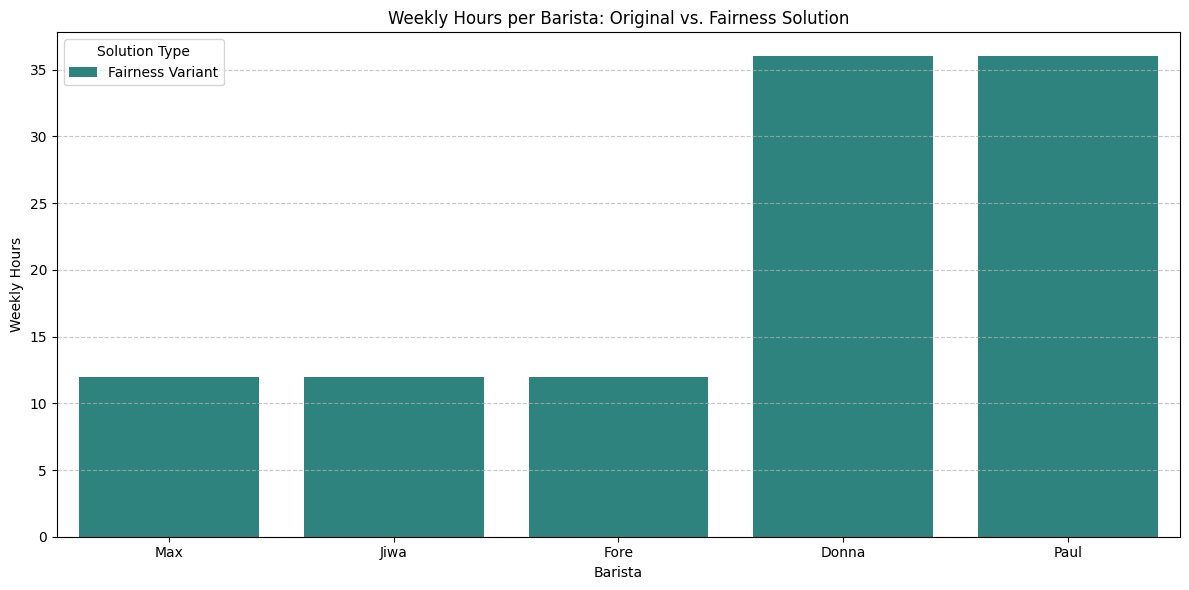

In [217]:
# Visualization: Weekly Hours per Barista
plt.figure(figsize=(12, 6))
sns.barplot(x='Barista', y='Weekly Hours', hue='Solution Type', data=df_combined_schedules, palette='viridis')
plt.title('Weekly Hours per Barista: Original vs. Fairness Solution')
plt.ylabel('Weekly Hours')
plt.xlabel('Barista')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Solution Type')
plt.tight_layout()
plt.show()


### **Comparison of Weekly Costs**

Now, let's compare the weekly costs for each barista between the two solutions. This helps to understand if the fairness objective had any individual cost implications.

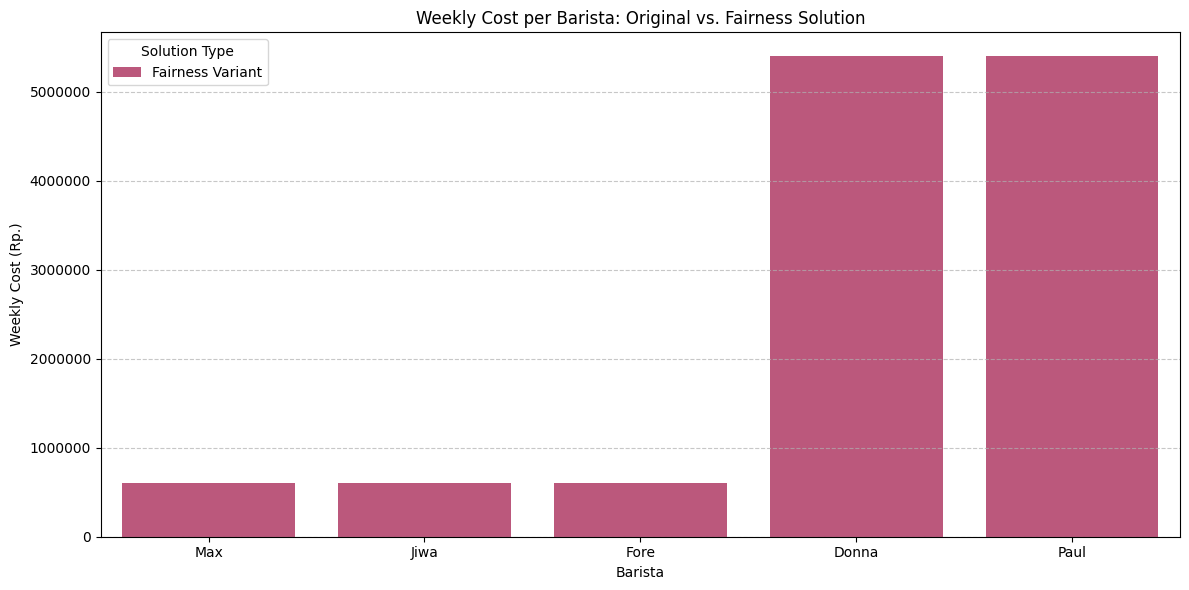

In [218]:
# Visualization: Weekly Cost per Barista
plt.figure(figsize=(12, 6))
sns.barplot(x='Barista', y='Weekly Cost', hue='Solution Type', data=df_combined_schedules, palette='plasma')
plt.title('Weekly Cost per Barista: Original vs. Fairness Solution')
plt.ylabel('Weekly Cost (Rp.)')
plt.xlabel('Barista')
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation for currency
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Solution Type')
plt.tight_layout()
plt.show()
